## Tinder Swindler 100k Tweets

In [135]:
# load the dataset
import pandas as pd

file = './TinderSwindlerVersion2.csv'
df = pd.read_csv(file)

In [136]:
df.head(10)

,user_name,user_location,user_created,user_followers,user_verified,date,text,source,is_retweet
0,globalnode.saito 🟥🐳🐈‍⬛,Travelling the World on Web3,2009-06-03 20:18:22+00:00,768,False,2022-02-09 17:09:22+00:00,"@T1gmee Tinder Swindler, off Netflix",Twitter for iPhone,False
1,Ungovernable 🇧🇮,NaN,2011-09-04 22:46:26+00:00,385,False,2022-02-09 17:09:18+00:00,"#tinderswindler , basically homeboy got away w...",Twitter for iPhone,False
2,Adefolake,NaN,2009-06-02 14:18:44+00:00,1994,False,2022-02-09 17:09:17+00:00,Not the tinder swindler becoming a TIk Tok sta...,Twitter for iPhone,False
3,✧ ☽,Noord-Brabant,2012-02-12 07:35:26+00:00,336,False,2022-02-09 17:09:07+00:00,Why isn’t Shimon Hayut in jail ????? #thetinde...,Twitter for iPhone,False
4,chivo. 🥶,PG/MD,2010-03-22 21:23:17+00:00,1046,False,2022-02-09 17:09:06+00:00,the tinder swindler a sick nigga 😂😂,Twitter Web App,False
5,kira,"Toronto, Ontario",2010-07-02 12:50:53+00:00,362,False,2022-02-09 17:09:03+00:00,No those women on the Tinder swindler pissed m...,Twitter for iPhone,False
6,fogmistress698,NaN,2020-05-05 08:47:57+00:00,210,False,2022-02-09 17:08:55+00:00,This manipulation is how scammers pull you in ...,Twitter Web App,False
7,melraunch,"East, England",2019-05-24 23:18:01+00:00,3268,False,2022-02-09 17:08:45+00:00,@robertstweets1 @DistantFixed I waited for him...,Twitter for iPhone,False
8,Pamela Power,"Johannesburg, South Africa",2009-07-10 12:51:24+00:00,6306,False,2022-02-09 17:08:41+00:00,Hmmm...he's like the #tinderswindler https://t...,Twitter for Android,False
9,CaliMcCormac,NaN,2022-02-09 16:48:06+00:00,0,False,2022-02-09 17:08:40+00:00,Wow just watching the Twitter Swindler and it ...,Twitter for iPhone,False


### Data Cleansing

In [137]:
df.isna().sum()

user_name             5
user_location     18481
user_created          0
user_followers        0
user_verified         0
date                  0
text                  0
source                0
is_retweet            0
dtype: int64

In [138]:
df["user_name"].fillna('unknown', inplace=True)
df["user_location"].fillna('unknown', inplace=True)

In [139]:
import re
# Remove urls from tweets
df.text = df.text.apply(lambda text: re.sub(r'http\S+|http', '', text))

In [140]:
df = df[df.is_retweet != True]

In [141]:
df.describe(include= "O").T

,count,unique,top,freq
user_name,76213,49767,.,196
user_location,76213,17911,unknown,18485
user_created,76213,54501,2020-10-06 00:15:38+00:00,160
date,76213,70999,2022-02-07 21:13:06+00:00,5
text,76213,73948,The Tinder Swindler,69
source,76213,210,Twitter for iPhone,47828


In [174]:
df_sample = df.sample(10000)

### Load Spacy and init stop words

In [175]:
import spacy

from spacy.tokenizer import _get_regex_pattern
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

nlp = spacy.load('en_core_web_lg')

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add patterns for hashtags and in-word hyphens
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderkneis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [176]:
# extend stop words if needed
stop_words.extend([])

#### Create docs via spacy

In [177]:
# create docs list with nlp
docs = list(nlp.pipe(df_sample.text, n_process=6))

In [178]:
doc_vectors = [doc.vector for doc in docs]

In [179]:
docs[4]

I’m a homeless king killed me skskskks #tinderswindler

### Get Hashtags and Emoji

In [180]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)
pattern = [{"TEXT": {"REGEX": "^#\w+|\w+-\w+"}}]
matcher.add('HASHTAG', [pattern])

def getHashtags(doc):
    matches = matcher(doc)
    hashtags = []
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
        text = re.sub('[^A-Za-z0-9_-]+', '', span.text)
        hashtags.append(text)
    return hashtags

# getHashtags(docs[15])
# >>> ['tinderswindler']

In [181]:
# create list of hastags
hashtags = [item for sublist in list(getHashtags(doc) for doc in docs) for item in sublist]

In [182]:
from collections import Counter
counter = Counter()

for tag in hashtags:
    counter[tag] += 1

pprint(counter.most_common(50))

[('tinderswindler', 1989),
 ('TheTinderSwindler', 1401),
 ('TinderSwindler', 314),
 ('Netflix', 64),
 ('thetinderswindler', 30),
 ('simonleviev', 28),
 ('TindlerSwindler', 17),
 ('netflix', 16),
 ('Tinderswindler', 13),
 ('Tinder', 11),
 ('tinder', 11),
 ('_', 10),
 ('SimonLeviev', 9),
 ('NFT', 9),
 ('AFCON2021', 8),
 ('SaveRayan', 7),
 ('Rayan', 6),
 ('1', 6),
 ('MasculinitySaturday', 6),
 ('true-crime', 6),
 ('M-PESA', 6),
 ('trakt', 6),
 ('theTinderSwindler', 6),
 ('Taooma', 5),
 ('TheTindlerSwindler', 5),
 ('StayAlive_CHAKHO', 5),
 ('VoetsekEFF', 5),
 ('BBMzansi', 5),
 ('lovescams', 4),
 ('bell-end', 4),
 ('Simon', 4),
 ('VirtualSlumberParty', 4),
 ('TikTok', 4),
 ('jet-setting', 4),
 ('Beijing2022', 4),
 ('Crypto', 4),
 ('long-term', 3),
 ('ShimonHayut', 3),
 ('NowWatching', 3),
 ('datingscams', 3),
 ('ValentinesDay', 3),
 ('DatingApp', 3),
 ('Documentary', 3),
 ('web3', 3),
 ('OAUTwitter', 3),
 ('ThePuppetMaster', 3),
 ('dating', 3),
 ('thepuppetmaster', 3),
 ('Bitcoin', 3),
 ('R

In [282]:
import spacy
from spacymoji import Emoji

ImportError: cannot import name 'UNICODE_EMOJI' from 'emoji' (/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/emoji/__init__.py)

In [270]:
# create list of hastags
for token in docs[0]:
    print(token.text, token.pos_, token.tag_, token.dep_)

I PRON PRP nsubj
’m AUX VBP aux
enjoying VERB VBG ROOT
Simon PROPN NNP poss
’s PART POS case
meltdown NOUN NN dobj
😂 PRON DT dobj
😂 PRON DT dobj
🤣 VERB VBP dobj
#TheTinderSwindler ADJ JJR dobj


### First explorative Analysis

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 0, 'Count')

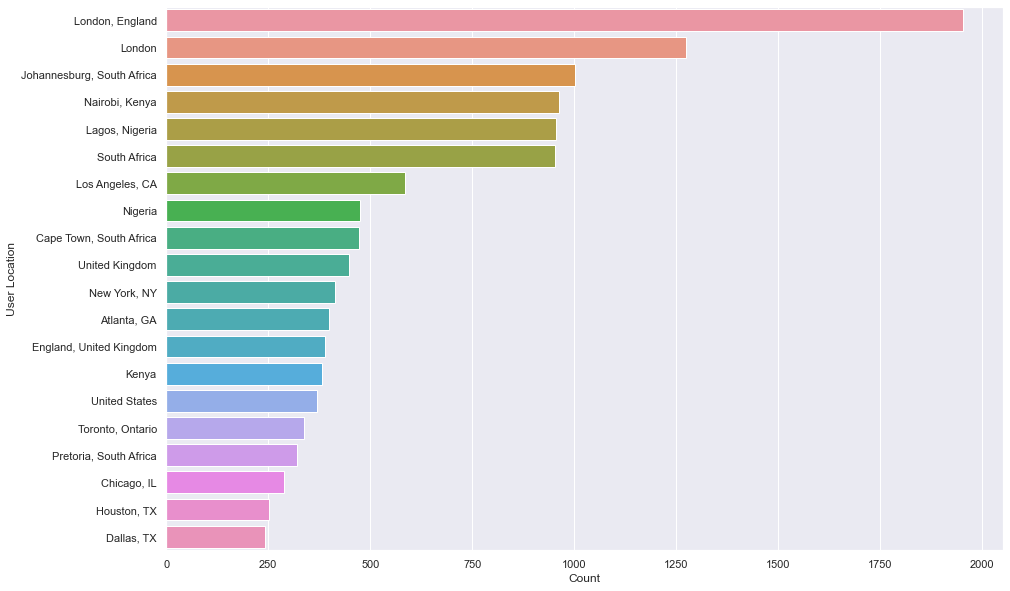

In [247]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(y="user_location", data=df[df["user_location"] != "unknown"], order=df[df["user_location"] != "unknown"]['user_location'].value_counts().index[0:20])
ax.set_ylabel("User Location")
ax.set_xlabel("Count")

In [248]:
df['datetime_date'] = pd.to_datetime(df['date']).dt.date

In [249]:
df_datecount = df.groupby(by="datetime_date")['datetime_date'].count().reset_index(name="count")

In [250]:
df_datecount

,datetime_date,count
0,2022-02-01,80
1,2022-02-02,3130
2,2022-02-03,6725
3,2022-02-04,9080
4,2022-02-05,13420
5,2022-02-06,14831
6,2022-02-07,11798
7,2022-02-08,11042
8,2022-02-09,6107


Text(0.5, 0, 'Date')

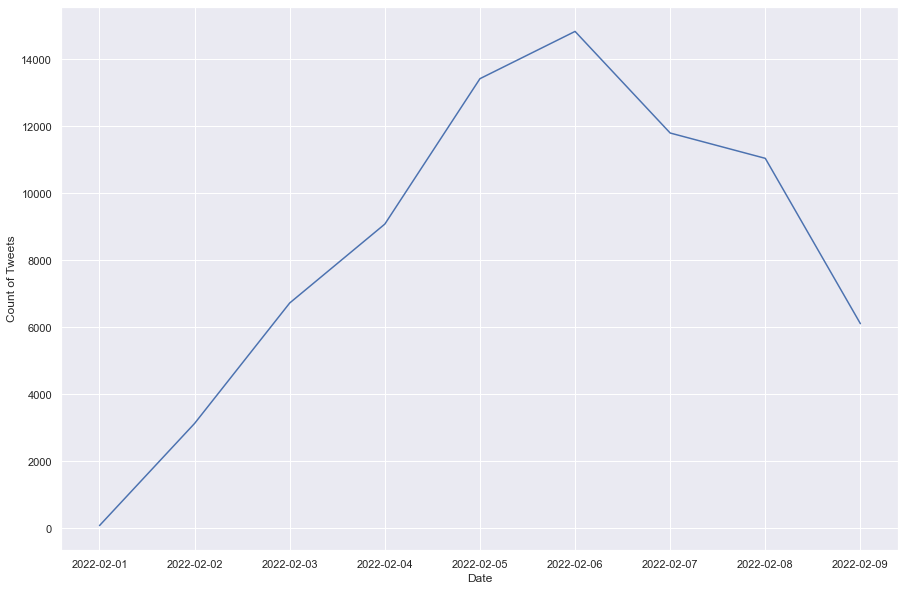

In [255]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.lineplot(data=df_datecount,x=df_datecount["datetime_date"], y=df_datecount['count'].value_counts().index)
ax.set_ylabel("Count of Tweets")
ax.set_xlabel("Date")

The film was released on Netflix on February 2, 2022

### Document Term Matrix

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Count Vectorizer
vect = CountVectorizer(stop_words=stop_words)  
vects = vect.fit_transform(df_sample.text)

# Select the first five rows from the data set
td = pd.DataFrame(vects.todense()).iloc[:9]  
td.columns = vect.get_feature_names_out()
term_document_matrix = td.T
term_document_matrix.columns = ['Doc '+str(i) for i in range(1, 10)]
term_document_matrix['total_count'] = term_document_matrix.sum(axis=1)

# Top 25 words 
term_document_matrix = term_document_matrix.sort_values(by ='total_count',ascending=False)[:25] 

# Print the first 10 rows 
print(term_document_matrix.drop(columns=['total_count']).head(10))

                   Doc 1  Doc 2  Doc 3  Doc 4  Doc 5  Doc 6  Doc 7  Doc 8  \
swindler               1      0      1      0      1      0      0      1   
tinder                 1      0      1      0      1      0      0      0   
thetinderswindler      0      1      0      1      0      0      1      0   
watching               0      0      0      2      0      0      0      0   
like                   1      0      0      1      0      0      0      0   
real                   0      1      0      0      0      0      0      0   
movie                  1      0      0      1      0      0      0      0   
checked                0      1      0      0      0      0      0      0   
series                 0      0      0      1      0      0      0      0   
crazy                  0      0      0      1      0      0      0      0   

                   Doc 9  
swindler               1  
tinder                 1  
thetinderswindler      0  
watching               0  
like             

<AxesSubplot:>

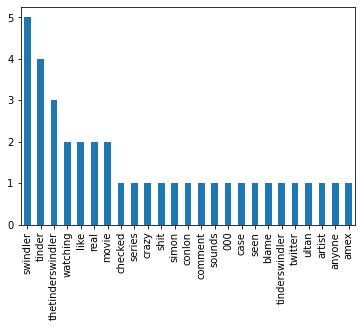

In [ ]:
term_document_matrix['total_count'].plot.bar()

### Cosine Similarity

In [183]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(doc_vectors)

In [184]:
similarity[similarity < 0.95] = 0

In [185]:
from pprint import pprint

pprint(similarity)

array([[1.0000004, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.0000001, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.9999996, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 1.0000001,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.0000001]], dtype=float32)


In [186]:
import networkx as nx
G = nx.from_numpy_array(similarity)


KeyboardInterrupt: 

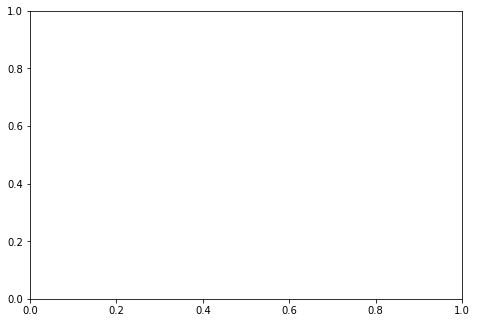

In [187]:
nx.draw(G)